# 1. Forutsetninger
Målet med denne notatboken er å få en forholdsvis enkel introduksjon til *reinforcement learning* (eller *forsterkende læring* på norsk), som er en gren av maskinlæring.

Vi skal løse problemet vist i denne videoen (NB. Kan være lurt å skru av lyd): https://www.youtube.com/watch?v=5Q14EjnOJZc.

Språket som benyttes er Python.

Notatboken består av delvis fullstendige, delvis ufullstendige funksjoner, kodesnutter og klasser. Oppgavene vil bestå i å fullføre de ufullstendige funksjonene og klassene, samt i å eksperimentere med ulike innstillinger for å oppnå bedre resultater på modeller laget for å løse problemet.

For å utføre ("eksekvere") koden i en celle i notatboken kan du bruke snarveien Shift+ENTER.

# 2. Nødvendige installasjoner

Vi trenger å installere noen få ekstra biblioteker for å få kjørt koden vår.

In [ ]:
# Vi trenger dette for å vise videoer av oppførselen til modellene og strategiene vi lager.
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*

# 3. Hjelpeoppsett for visualisering

Vi begynner med litt generelt oppsett for å ta opp og vise videoer av modeller. Disse cellene trenger du bare å eksekvere (Shift + ENTER).

In [ ]:
# Hjelpefunksjon for å spille av videoer

from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Denne funksjonen returnerer en streng som inneholder en base64-enkodet versjon av en MP4-video på angitt sti.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
# Importer et bibliotek for å embedde en MP4-video i et HTML-miljø
from IPython.display import HTML

For å vise en video lagret på `videopath` trenger du nå bare å skrive følgende kode:

```
html = render_mp4(videopath)
HTML(html)
```



Før vi går videre må vi instansiere et virtuelt display som kan håndtere visualisering for oss.

In [ ]:
# Start opp en instans av et virtuelt display
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()

# 4. CartPole-miljøet

Vi bruker et Python-bibliotek som heter `gym.openai`. Dette biblioteket er tilrettelagt for å studere en lang rekke *miljøer* ("environments") som er velegnet for reinforcement learning. I reinforcement learning er målet å trene en modell til å løse et fysisk problem ved å gi høyere poengsum jo nærmere modellen kommer å oppføre seg slik vi ønsker. Bak panseret brukes avansert matematikk for å søke etter de optimale input-verdiene som maksimerer poengsummen. Vi vil her få anlendning til å se noe av denne matematikken.

Ordet "modell" i maskinlæring kan godt tenkes på som en funksjon av mange variable, både diskret og kontinuerlige, som man er kommet fram til ved å trene på en lang rekke kjente inputdata med tilhørende observasjoner av en "output"- eller "target"-variabel.

Vi skal studere *CartPole*-miljøet, et problem fra fysikken der studieobjektet er en vertikal stang montert på en bil. Bilen kan bevege seg i 2 retninger langs en fast horisontal akse. En slik stang er i ustabil likevekt og vil tippe mot høyre eller venstre ved små forstyrrelser. Målet er å holde stangen oppreist ved å respondere på hver enkelt forflytning av stangens topp. En *respons* ("action") kan være å gi bilen et dytt til venstre (0) eller et dytt til høyre (1).

Miljøets *tilstand* ("state") er til enhver tid beskrevet av fire variable:

1. Bilens posisjon
2. Bilens hastighet
3. Stangens vinkel målt mot en loddrett akse
4. Stangens vinkelhastighet.

Når vi skal trene en modell til å holde stangen oppreist skjer det gjennom flere *episoder*. En episode er et sett med *steg* ("steps"); for hvert steg skjer to ting:
- Man kan lese ut miljøets nåværende tilstand og får anledning til å reagere ved å dytte bilen mot venstre eller høyre.
- Miljøets tilstand oppdaterer seg som en respons på denne handlingen ("action")

"Å løse miljøet" betyr at man klarer å finne en universell måte å respondere på som gjør at stangen holdes oppreist i gjennomsnittlig mer enn 195 steg, målt over 100 påfølgende episoder. En episode varer et bestemt antall steg (minst 200), med mindre den termineres som følge av at miljøet *feiler*.

Miljøet feiler og episoden termineres dersom en av følgende skjer:
- stangens vinkel målt mot en vertikal linje blir større enn ±12° (ca 0.21 radianer)
- bilen beveger seg mer enn ±2.4

Oppgaven er altså å sørge for at dette ikke skjer.

Dokumentasjonen til `gym.openai` ligger på https://gym.openai.com/docs/

La oss starte med å lage et CartPole-miljø og studere det litt.

In [ ]:
import gym
import numpy as np

# Her oppretter vi miljøet vi skal studere
env = gym.make('CartPole-v0')

# Skriv ut en beskrivelse av miljøet:
print('Observation Space:', env.observation_space)
print('Action Space:', env.action_space)

print("Observation Space Param:   Cart Position | Cart Velocity | Pole Angle | Pole Velocity", )
print("Observation Space Highs:  ", env.observation_space.high)
print("Observation Space Lows:   ", env.observation_space.low)

Hvordan tolker du utskriften over?

**Oppgave 1:**
Vi skal nå eksperimentere litt med miljøet. Først må miljøet resettes:

`env.reset()`

Dette sørger for å stille inn alle miljøets 4 variable til små utgangspunktsverdier.

Skriv en løkke som itererer 200 ganger, og for hver iterasjon generer en *random action* (altså et tilfeldig tall lik enten 0 eller 1), og deretter utfører denne handlingen på miljøet:
- For å generere et tilfeldig tall kan du bruke Numpy-funksjonen
`np.random.randint`.
- For å utføre en handling `action` på miljøet kan du bruke 
`env.step(action)`. Kan du finne ut hva denne funksjonen returnerer? Ta gjerne en titt i dokumentasjonen til `gym.openai`.

Skriv ut informasjonen du får hver gang det utføres en handling på miljøet. Hvordan tolker du hva som skjer med miljøet etterhvert?

In [ ]:
# SKRIV KODEN DIN HER

Du kan gjøre opptak av oppførselen til miljøet underveis, ved hjelp av koden under:

```
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# Definer en VideoRecorder først
video = VideoRecorder(env, 'passende navn på video.mp4')

env.render()
video.capture_frame()
```

Du må kalle
```
video.close()
env.close()
```
når du er ferdig. Deretter kan du hente fram videoen og se på den slik:
```
html = render_mp4(videopath)
HTML(html)
`````

Hva syns du?

In [ ]:
# SKRIV KODEN DIN HER

# 5. Strategier
En *strategi* er en definert tilnærming for å løse CartPole-miljøet. Vi vil implementere strategier som *klasser* (se definisjon under).

**Definisjon:** I så godt som alle moderne programmeringsspråk har man muligheten til å definere sine egne typer, kalt *klasser*. En klasse består av medlemsvariable og -funksjoner. En instans av en klasse kalles et *objekt*. I Python har en klasse tilgang på sine egne funksjoner og variable gjennom en variabel som heter `self`. Alle medlemsfunksjoner av en klasse tar `self` som første parameter og kan endre på medlemsvariablene til den instansen av klassen de kalles innnenfor.

Her er litt enkel bruk av klasser:

**Eksempel**:

```
class Eksempel():
  def __init__(self):
    self.variabel = 1

  def endre_variabel(self, tall):
    self.variabel = tall

a = Eksempel()     # a vil nå ha variabel == 1
a.endre_variabel(3) # a vil nå ha variabel == 3

b = Eksempel()     # b vil nå ha variabel == 1
b.endre_variabel(2) # b vil nå ha variabel == 2, a vil fortsatt ha variabel == 3
```


De klassene vi skal lage vil ha formen indikert nedenfor:

In [ ]:
class CartPoleStrategySkeleton():
    def __init__(self):
      # Her kan du definere hvilke operasjoner som skal utføres når et objekt av klassen instansieres
      pass

    def name(self):
      # Denne funksjonen skal returnere et passende navn/en passende beskrivelse av strategien
      return "PASSENDE_NAVN_PÅ_STRATEGIEN"

    def act(self, state):
      # Legg til kode her. Denne funksjonen vil kalles når vi skal beregne en handling å utføre på miljøet, gitt miljøets tilstand (input til funksjonen).
      action = 0
      # ...
      return action

    def update(self):
      # Legg til kode her. Denne funksjonen er ment å kalles etter en fullført episode i tilfelle det er oppdateringer av klassevariable som må utføres på det tidspunktet.
      pass

    def memorize(self, state, action, reward, done):
      # Legg til kode her. Denne funksjonen er ment å kalles etter hver gang en handling er utført på miljøet, i tilfelle det er oppdateringer av klassevariable som må utføres på dette tidspunktet.
      pass
    

Koden over er en generell beskrivelse av strategiklassene vi skal skrive. Vi trenger også å skrive en funksjon som styrer treningen av en modell ved hjelp av en strategiklasse.

**Oppgave 2:** Skriv en funksjon `run_cartPole` som tar inn en strategiklasse som parameter og gjør følgende steg:
1. Lager en instans `env` av et `CartPole-v0`-miljø.
2. Itererer over 200 episoder, hver av dem på max 250 steg, og for hver episode forsøker å løse miljøet. Bruk funksjonene `act`, `memorize` og `update` til strategien.
3. Gjør videoopptak av oppførselen til miljøet underveis ved hjelp av følgende kommandoer:

```
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# Definer en VideoRecorder først
video = VideoRecorder(env, 'passende navn på video.mp4')

env.render()
video.capture_frame()
```

4. Ta vare på en liste `scores` med belønningene du får underveis (for hver episode).

5. Funksjonen skal returnere listen `scores`. Husk at miljøet kun anses som løst dersom man klarer å holde stangen oppreist i 195 steg i 100 episoder etter hverandre (gjennomsnittlig).

6. Du må kalle
```
video.close()
env.close()
```
på slutten av funksjonen, før koden returnerer.

In [ ]:
import numpy as np

from gym.wrappers.monitoring.video_recorder import VideoRecorder

def run_cartPole(policy):
    print('Evaluerer {}'.format(policy.name()))

    # Definer miljøet
    env = gym.make('CartPole-v0')
    # Disse to linjene sørger for at ting er reproduserbart hver gang vi kjører koden
    env.seed(0)
    np.random.seed(0)

    video = VideoRecorder(env, "LAG_ET_PASSENDE_NAVN_PÅ_VIDEO")

    scores = []

    for i_episode in SETT_INN_PASSENDE_MENGDE_EPISODER:
        # Resett miljøet
        state = env.reset()

        for t in SETT_INN_PASSENDE_ANTALL_STEG:
            action = # hent ut riktig handling å utføre fra policy
            # Etter å ha hentet ut riktig handling (action) må du utføre denne handlingen på miljøet med env.step(action) og ta vare på output
            # Etter å ha utført handlingen på miljøet må du kalle policy sin memorize-funksjon

            ######
            # Disse to linjene sørger for at det gjøres videoopptak av miljøet
            env.render()
            video.capture_frame()
            ######

            if # SJEKK OM MILJØET HAR FEILET ELLER FULLFØRT RIKTIG ANTALL STEG (195):
                break

        scores.append(TOTAL_BELØNNING_DU_FIKK_I_DENNE_EPISODEN)

        # Etter en fullført episode må du kalle update-funksjonen til policy
        
        # Litt utskrift av statistikk her...
        start = max(0, i_episode-100)
        print('Episode {}\tAverage score last runs: {:.2f}\t Last score: {}'.format(i_episode, np.mean(scores[start:]), scores[-1]))
        if np.mean(scores[start:]) >= 195.0 and len(scores[start:]) >= 100:
            print('** Environment solved in {:d} episodes!\tAverage score: {:.2f}'.format(max(1, i_episode-100+1), np.mean(scores[start:])))
            break

    start = max(0, i_episode-100)
    if np.mean(scores[start:]) < 195.0:
        print('** The environment has never been solved!')
    
    # STENG MILJØ OG VIDEOOPPTAK HER
    ######
    # ....
    ######
    
    return scores

**Oppgave 3a):** Test dette oppsettet på en strategi som alltid returnerer 1 (dytt mot høyre). Du kan utelate implementasjonen av funksjonene `update`, og `memorize`, de trengs ikke for en så enkel strategi (bruk Python-nøkkelordet `pass`). Men du må implementere funksjonen `act`.

Hvordan fungerer denne strategien på å løse miljøet?

In [ ]:
class Policy_Always1():
    def __init__(self):
      pass

    def name(self):
      # IMPLEMENTERES

    def act(self, state):
      # IMPLEMENTERES

    def update(self):
      pass

    def memorize(self, state, action, reward, done):
      pass


In [ ]:
# Her kjører vi strategien
policy_always = Policy_Always1()
scores_always = run_cartPole(policy_always)

**Oppgave 3b)**
Hent fram videopptaket du har gjort av oppførselen til strategien over tid. Hva skjer?

In [ ]:
# KJØR KODE HER

# 6. Funksjoner som tegner utviklingen til en strategi

For å få bedre innblikk i hvordan en strategi potensielt tilnærmer seg en løsning på problemet, trenger vi å tegne oppførselen til strategien over flere episoder.

**Oppgave 4a)**

Bruk `matplotlib.pyplot` sin funksjon `scatter` til å skriv en funksjon `plot_performance`, som tar inn en liste `scores`, og tegner et scatter plot over disse langs y-akse mot episode på x-akse. Du kan bruke y-verdien til å fargelegge punktene. Prøv også å bruke koden under

```
fit = np.polyfit(x, y, deg=?)
p = np.poly1d(fit)
```

til å lage et polynom som interpolerer ("tilnærmer") y-verdiene, og plot grafen til dette polynomet. Dette kan gjøre det lettere å se om strategien utvikler seg på positivt vis over tid. Hva slags grad (`deg`) er det fornuftig å bruke på polynomet?

**Oppgave 4b)**
Skriv en funksjon `plot_histogram_scores`, som tar inn en liste `scores`, og tegner et histogram over fordelingen til belønningene per episode.


In [ ]:
import matplotlib.pyplot as plt

def plot_performance(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = # DEFINERES AV DEG
    y = # DEFINERES AV DEG
    plt.scatter(# PUTT INN RIKTIGE PARAMETRE)
    fit = np.polyfit(x, y, deg=#SETT INN RIKTIG GRAD)
    p = np.poly1d(fit)
    plt.plot(# PUTT INN RIKTIGE PARAMETRE)
    plt.xlabel('Episode #')
    plt.ylabel('Score')
    plt.title('Strategiytelse over tid')
    plt.show()

def plot_histogram_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Finn en passende funksjon i plt for å tegne et histogram over scores
    plt.xlabel('Belønning per episode')
    plt.ylabel('Frekvens')
    plt.title('Distribusjon av belønninger per episode')
    plt.show()

**Oppgave 4c)** Gjør et kall av disse funksjonene på `scores` som du allerede har hentet ut.

In [ ]:
# KJØR KODEN HER

# 7. Noen andre strategier

Den forrige strategien var å alltid respondere med samme svar, uavhengig av hva miljøets tilstand tilsa. Vi kan istedet forsøke å variere mellom de to ulike handlingene 0 (dytt mot venstre) og 1 (dytt mot høyre). Den aller enkleste måten å variere på er å returnere et tilfeldig svar.

**Oppgave 5:** Implementer en slik strategiklasse. De trenger kun å implementere `act`-funksjonen. Tegn deretter ut de samme plottene som forrige gang, og inspiser videopptaket. Hvordan er denne strategien sammenlignet med den forrige? Hvorfor?

In [ ]:
class Policy_Random():
    def __init__(self):
      pass

    def name(self):
      # IMPLEMENTERES

    def act(self, state):
      # IMPLEMENTERES

    def update(self):
      pass

    def memorize(self, state, action, reward, done):
      pass


In [ ]:
policy_random = Policy_Random()
scores_random = run_cartPole(policy_random)

In [ ]:
# KODE FOR PLOTTING AV GRAFER HER

In [ ]:
# KODE FOR Å HENTE UT VIDEO HER

La oss forsøke å forbedre strategien enda litt mer. Det kan vi gjøre ved å faktisk tilpasse handlingen etter hvordan miljøets tilstand er. For eksempel kan vi skyve bilen mot venstre dersom stangen tipper i denne retningen. Og mot høyre hvis den tipper i den retningen.

**Oppgave 6:**
Skriv en slik strategiklasse, `Policy_BasicConditionalBangControl`. Du trenger kun å implementere `act`-funksjonen. Tegn ut de samme plottene som tidligere og inspiser videopptaket. Hvordan er oppførselen til strategien nå?

In [ ]:
class Policy_BasicConditionalBangControl():
    def __init__(self):
      pass

    def name(self):
      # IMPLEMENTERES

    def act(self, state):
      # IMPLEMENTERES

    def update(self):
      pass

    def memorize(self, state, action, reward, done):
      pass


In [ ]:
policy_bang = Policy_BasicConditionalBangControl()
scores_bang = run_cartPole(policy_bang)

In [ ]:
# KODE FOR PLOTTING AV GRAFER HER

In [ ]:
# KODE FOR Å HENTE UT VIDEO HER

**Oppgave 7:** Kan du komme på en egen strategi for å løse problemet? For eksempel forbedre tilnærmingen over og skrive en `Policy_ImprovedConditionalBangControl`? *Hint*: Her gjelder det å se på andre parametre som beskriver miljøets tilstand, i hovedsak stangens vinkelhastighet og bilens hastighet.

Tegn ut ytelsesplottene og inspiserer videopptaket av strategilæringen som før. Hva syns du?

In [ ]:
class Policy_ImprovedConditionalBangControl():
    def __init__(self):
      pass

    def name(self):
      # IMPLEMENTERES

    def act(self, state):
      # IMPLEMENTERES

    def update(self):
      pass

    def memorize(self, state, action, reward, done):
      pass


In [ ]:
policy_improved = Policy_ImprovedConditionalBangControl()
scores_improved = run_cartPole(policy_improved)

In [ ]:
# KODE FOR PLOTTING AV GRAFER HER

In [ ]:
# KODE FOR Å HENTE UT VIDEO HER

# 8. Hill climbing

For å løse miljøet er en mulig tilnærming å vekte de forskjellige variablene som beskriver tilstanden til miljøet. Med andre ord, vi må prøve å finne vekter (reelle tall) `w_1, w_2, w_3 og w_4` slik at summen

`w_1 * bilens_posisjon + w_2 * bilens_hastighet + w_3 * stangens_vinkel + w_4 * stangens_vinkel_hastighet`

entydig forteller oss om vi skal dytte bilen mot høyre eller venstre. Den enkleste måten å la en slik sum avgjøre et valg som i utgangspunktet bare har to muligheter (venstre eller høyre, 0 eller 1), er å se på om den er positiv eller negativ. Vi kan for eksempel si at dersom summen, for gitte vekter `w_1, ... w_4`, er negativ, så skal vi dytte bilen mot venstre, mens vi skal dytte mot høyre om den er positiv.

**Oppgave 8a)** Skriv en strategiklasse `PolicyReinforcementLearning` som eier en liste `self.w` med fire reelle vekter, og som implementerer funksjonen `act` ved å sjekke om summen gjengitt ovenfor er positiv eller negativ. Du kan sette alle fire vektene til f. eks. 0.1 i `__init__`-funksjonen til klassen.

**Oppgave 8b)** *Reinforcement learning* betyr at vi søker å belønne riktig atferd i strategiklassen. Det vil si at vi oppdaterer vektene `w_1, ... w_4` i strategiklassen etter hver fullendte episode basert på hvor høy score vi fikk. Var scoren høy tolker vi det som at vektene var "gode" og endrer dem ikke så mye. Var scoren lav tolker vi det som at vektene ikke var så gode, og vi endrer dem da litt mer før neste episode.

Dette betyr at vi er nødt til å ta vare på belønningene vi får for hver episode. Skriv funksjonen `memorize` i strategiklassen slik at den tar vare på belønningene for hver handling i en liste `self.rewards`.

**Oppgave 8c)** Du skal nå skrive funksjonen `update` slik at den oppdaterer vektene basert på om vi har klart å forbedre belønningen for handlingene våre. I avansert *reinforcement learning* bruker man gjerne noe som heter *backpropagation* for å beregne deriverte og *gradient descent* for å justere vektene i helt riktig retning. Dette blir for komplisert for dette kurset, istedet skal vi gjøre en enkel justering av vektene ved hjelp av tilfeldigheter.

Hvis belønningen har forbedret seg siden forrige episode, kan du justere vektene **litt** i tilfeldig retning, mens hvis belønningen har forverret seg må du justere vektene **mye**.

**Oppgave 8d)** Prøv å kjøre strategien nå. Fungerer det?

**Oppgave 8e)** For en enda bedre strategilæring kan det være lurt å legge mindre og mindre vekt på nyere belønninger. Dette hindrer læringen til strategien fra å bli overopphengt i de siste resultatene. Vi kan legge til en ny variabel `gamma` og bruke en vektet sum av de foregående belønningene som mål på godt vi har lykkes. Første belønning vektes med `gamma^0 = 1.0`, andre belønning med `gamma`, tredje med `gamma^2`, fjerde med `gamma^3` osv. Forsøk å variere variablen `gamma` mellom 0 og 1. Hvordan endrer oppførselen til strategilæringen seg?

In [ ]:
class PolicyReinforcementLearning():
    def __init__(self):
        self.rewards = [] # Starter med en tom liste av belønninger
        self.beste_resultat = -np.Inf # Vi starter ut lavest mulig
        self.siste_resultat = 0
        self.w = # sett til 4 passende initialvekter
        self.beste_w = self.w # beste vekter

    def name(self):
        # IMPLEMENTER 

    def act(self, state):
        # IMPLEMENTER.

    def memorize(self, state, action, reward, done):
        # IMPLEMENTER

    def update(self):
        if self.siste_resultat >= self.beste_resultat: # Vektene ble bedre enn før
            self.beste_resultat = # Hva skal vi oppdatere til?
            self.beste_w = # Hva skal vi oppdatere til?
        
        self.w = self.beste_w + np.random.rand(*self.w.shape) * # MULTIPLISER MED EN PASSENDE SKALERINGSFAKTOR
        self.rewards = []


In [ ]:
policy_reinforcement = PolicyReinforcementLearning()
scores_reinforcement = run_cartPole(policy_reinforcement)

In [ ]:
# KODE FOR PLOTTING AV GRAFER HER

**Oppgave 8f)** Se på videopptaket av strategiens oppførsel. Hva synes du?

In [ ]:
# KODE FOR Å HENTE UT VIDEO HER

**Oppgave 8g)** Ta vare på vektene som genereres av strategiklassen underveis, i en variabel `self.w_history`. Skriv en funksjon `plot_weights_history` som tegner utviklingen til hver av dem som funksjon av antall episoder. Hva observerer du?

In [ ]:
def plot_weights_history(weights_history):
    weights_history = np.array(weights_history)
    plt.figure(0)
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.6, hspace=.5)
    for i in range(weights_history.shape[1]):
        plt.subplot(2, 2, i + 1)
        # Her plotter du utviklingen til vekt for tilstandsvariabel nr. i

        plt.title('Vekt for miljøtilstandsparameter {}'.format(i))

In [ ]:
# PLOTT VEKTHISTORIKKEN HER

Det vi har konstruert nå er et veldig enkelt kunstig nevralt nettverk med ett lag som kun manipulerer input-data med vekter, summerer og anvender en aktiveringsfunksjon. Dette kalles et *perseptron*:

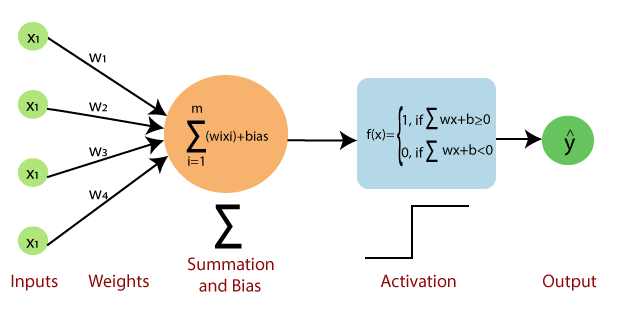

Metoden vi har brukt kalles gjerne "hill climbing" fordi vi klatrer opp et fjell (i fire dimensjoner, én for hver av variablene som beskriver miljøet) til vi når toppen (beste mulige vekter).

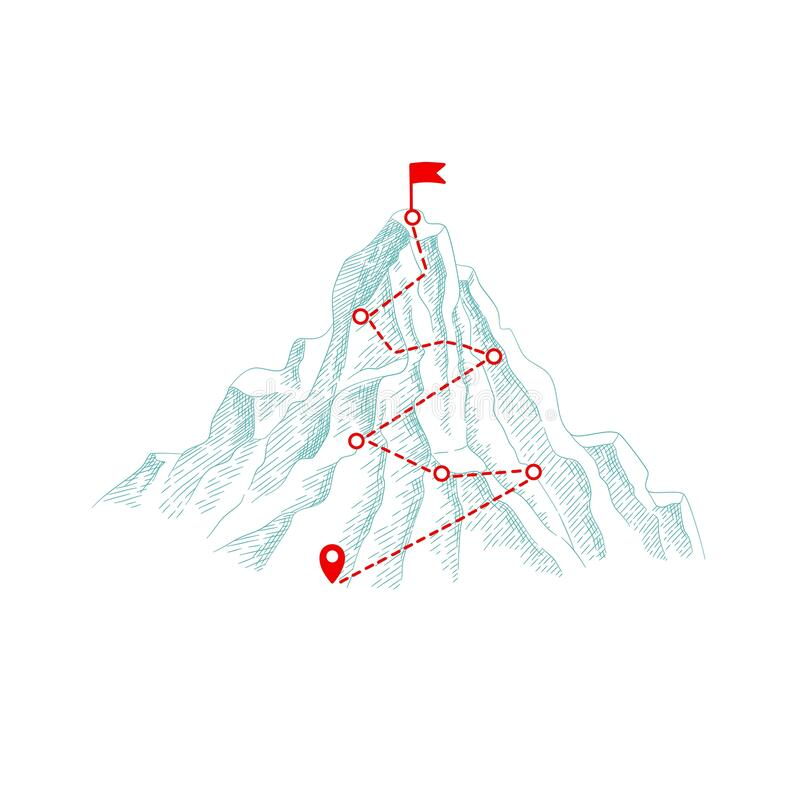

Du kan lese mer om nevrale nettverk her:
- https://towardsdatascience.com/machine-learning-for-beginners-an-introduction-to-neural-networks-d49f22d238f9
- https://www.lesswrong.com/posts/Madwb2t79LGrLqWLH/a-simple-introduction-to-neural-networks (denne krever en del mer matematikk)

Med denne tilnærmingen ser det tilsynelatende ut til at vi har greid å holde stangen oppreist, men likefullt kan det virke som om strategien favoriserer at stangens toppunkt ikke skal bevege seg så mye. Det er muligens ikke så lurt i det lange løp. Funksjonen under kan brukes til å verifisere om strategien holder over lenger tid:

In [ ]:
import requests

def validate_policy(policy, stable = False, write_score = False, player_name = "Test", board_code=""):
    name = policy.name()
    print("Validerer strategien {}...".format(name))
    max_t = 500 # Høyt antall makssteg

    # Definer miljøet
    env = gym.make('CartPole-v0')    
    
    if stable:
        # Disse to linjene sørger for at ting er reproduserbart
        env.seed(2022)
        np.random.seed(2022)

    video_name = "Validation_{}.mp4".format(name)
    video = VideoRecorder(env, video_name)

    state = env.reset()
    rewards = []    

    for t in range(max_t): # Maksium antall steg 
        action = policy.act(state) # Finn hvilken handling vi skal gjøre
        state, reward, done, info = env.step(action) # Utføre handlingen
        rewards.append(reward) # Legg til belønning
        env.render()
        video.capture_frame()
      
    print("Strategien fikk en score på {}".format(sum(rewards)))
    video.close()
    env.close()

    if write_score:
        id = -1
        previous_score = 0
        r = requests.get("https://keepthescore.co/api/{}/board/".format(board_code))
        for player in r.json()['players']:
            if player['name'] == player_name:
                id = player['id']
                previous_score = player['score']
                break
        if id != -1:
            print('Bruker allerede registrert...')
        else:
            print('Registrerer ny bruker...')
            r = requests.post("https://keepthescore.co/api/{}/player/".format(board_code), json={"name": player_name})
            print(r.status_code, r.reason)
            for player in r.json()['players']:
                if player['name'] == player_name:
                    id = player['id']
                    break
        if id != -1:
            print('Skriver score til leaderboard...')
            r = requests.post("https://keepthescore.co/api/{}/score/".format(board_code), json={"player_id": id, "score": sum(rewards)-previous_score})
            print(r.status_code, r.reason)

    return sum(rewards), video_name

**Oppgave 9:** Sjekk strategien din med denne valideringsfunksjonen.

In [ ]:
points_reinformcenet, video_name_reinforcement = validate_policy(policy_reinforcement)

In [ ]:
html = render_mp4(video_name_reinforcement)
HTML(html)

Det er mulig å lage en enda bedre utgave av klassen over ved å finpusse tilnærmingen til `act`, som indikert nedenfor. Istedenfor å operere med 4 vekter som entydig skal fortelle oss om vi skal dytte mot høyre eller venstre, lager vi 4 vekter som skal fortelle oss hvor mye det kan lønne seg å dytte til venstre, og 4 vekter som skal fortelle oss hvor mye det kan lønne seg å dytte til høyre. Deretter velger vi den veien som lønner seg mest.

**Oppgave 10:** Skriv en forbedret utgave av forrige strategiklasse, der du vedlikeholder to vektlister istedenfor én, en for å beregne lønnsomheten til en venstre-*action*, og en for å beregne lønnsomheten til en høyre-*action*. I `act`-funksjonen velger du den handlingen som gir størst lønnsomhet. `memorize` er som før, og `update` må nå holde kontroll på to størrelser fremfor bare én.

In [ ]:
class PolicyImprovedReinforcementLearning():
    def __init__(self):
        self.rewards = [] # Starter med en tom liste av belønninger
        self.beste_resultat = -np.Inf # Vi starter ut lavest mulig
        self.siste_resultat = 0
        self.w_venstre = # sett til 4 passende initialvekter
        self.w_høyre = # sett til 4 passende initialvekter
        self.beste_w_venstre = # ?
        self.beste_w_høyre = # ?

    def name(self):
        # IMPLEMENTER

    def act(self, state):
        # Mulig løsning skissert under
        score_left = np.dot(state, self.w_left) # Skalarprodukt
        score_right = np.dot(state, self.w_right) # Skalarprodukt
        score_left_norm = np.exp(score_left) / (np.exp(score_left) + np.exp(score_right))
        score_right_norm = np.exp(score_right) / (np.exp(score_left) + np.exp(score_right))
        if score_left > score_right:
            return 0
        else:
            return 1

    def memorize(self, next_state, action, reward, done):
        # IMPLEMENTER

    def update(self):
        # IMPLEMENTER


In [ ]:
policy_improved_rl = PolicyImprovedReinforcementLearning()
scores_improved_rl = run_cartPole(policy_improved_rl)

In [ ]:
plot_performance(scores_improved_rl)
plot_histogram_scores(scores_improved_rl)

In [ ]:
plot_weights_history(policy_improved_rl.w_history_right)

In [ ]:
points_improved_rl, video_name_improved_rl = validate_policy(policy_improved_rl)

In [ ]:
html = render_mp4(video_name_improved_rl)
HTML(html)

## 9. Konkurranse

**Oppgave 11:** Bruk `validate_policy(policy, True, True, "DITT_BRUKERNAVN", board_code)` til å sjekke hvor god strategien din er. `board_code` får du fra instruktørene. Beste score vinner! :) Du kan forsøke å endre på strategien din ved behov. For eksempel stille inn på variable som `gamma` o.l. (i maskinlæring omtales slike variable gjerne som *hyperparametre* og prosessen med å finne de beste hyperparametrene for formålet til modellen kalles gjerne *hyperparameter-tuning*).

In [ ]:
validate_policy(policy, True, True, "DITT_BRUKERNAVN", spør_instruktør_om_board_code)

# 10. Trene en modell ved hjelp av ray.rllib

Det vi nå har gjort er å lage vår egen, helt grunnleggende *reinforcement learning*-algoritme, spesialtilpasset et konkret problem, med forholdsvis enkel matematikk. Det finnes mer generelle tilnærminger, som tar i bruk kraftigere matematiske verktøy og enkelt kan tilpasses andre problemer. For eksempel kan man benytte Rays bibliotek `RLLib`. Vi må da først installere biblioteket:

In [ ]:
!pip install 'ray[rllib]'

`RLLib` er ferdig tilpasset `gym.openai`.

In [ ]:
config = {                        # Det er mulig å modifisere konfigurasjonen - se https://docs.ray.io/en/latest/rllib-models.html
    "env": "CartPole-v0",         # Med dette forteller vi RLLib at vi jobber med CartPole-v0-miljøet som biblioteket allerede kjenner til
    "framework": "torch",         # Spesifiser hvilket maskinlæringsrammeverk som skal benyttes (PyTorch = "torch", Tensorflow = "tf")
    "model": {                    # Spesifiserer egenskaper ved det nevrale nettverket som skal benyttes til læring (se f.eks. https://en.wikipedia.org/wiki/Artificial_neural_network)
      "fcnet_hiddens": [32],      # Antall "hidden layers" i det nevrale nettverket
      "fcnet_activation": "linear"# Aktiveringsfunksjon, kan også være "tanh" (https://en.wikipedia.org/wiki/Hyperbolic_functions#Tanh), "relu" (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
    }
}  

In [ ]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

ray.shutdown()                        # Stop eventuelle instanser
ray.init(                             # Sett opp ny instans med visse parametre
    num_cpus = 3,
    include_dashboard = False,
    ignore_reinit_error = True,
    log_to_driver = False,
)
# https://docs.ray.io/en/latest/tune/api_docs/execution.html
analysis = ray.tune.run(              # Begynn trening
    "PPO",                            # Valg av innebygd treningsalgoritme
    config = config,                  # Konfigurasjon
    stop = { 
        "episode_reward_mean": 195    # Vi stopper treningen når snitt-belønning går over 195
    },                        
    checkpoint_at_end = True,         # Må tas vare på for gjenbruk etterpå
    verbose = 2                       # Hvor mye rapporteringer skal vi ha underveis i treningen?
)

In [ ]:
# Etter å trent ferdig kan vi hente ut beste resultat
trial = analysis.get_best_logdir("episode_reward_mean", "max")
checkpoint = analysis.get_best_checkpoint(
    trial,
    "training_iteration",
    "max"
)
trainer = PPOTrainer(config=config)
trainer.restore(checkpoint)

In [ ]:
vid = VideoRecorder(env, "RLLibTrening.mp4")
observation = env.reset()
done = False
while not done:
  env.render()
  vid.capture_frame()
  action = trainer.compute_action(observation)
  observation, reward, done, info = env.step(action)
vid.close()
env.close()

In [ ]:
html = render_mp4("RLLibTrening.mp4")
HTML(html)

Vi kan oversette til vårt oppsett med strategiklasser som følger: 

In [ ]:
class RLLibStrategi():
    def __init__(self, trainer):
        self.trainer = trainer

    def name(self):
        return "RLLibStrategi"

    def act(self, state):
        return self.trainer.compute_action(state)

    def memorize(self, next_state, action, reward, done):
        pass

    def update(self):
        pass

In [ ]:
policy_rl_lib = RLLibStrategi(trainer)

In [ ]:
score_rl_lib, vid_name_rl_lib = validate_policy(policy_rl_lib)

In [ ]:
html = render_mp4(vid_name_rl_lib)
HTML(html)

**Oppgave 12:** Eksperimenter med å endre konfigurasjonsinnstillinger på treningen av RLLib, hvordan påvirker det sluttresultatet?